<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [39]:
# Import Libraries

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import datasets
import seaborn as sns

#### 1. Load Data

In [40]:
# Read Data
diabetes_csv = 'diabetes.csv'

In [41]:
df = pd.read_csv(diabetes_csv)

#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [42]:
df.shape

(768, 9)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


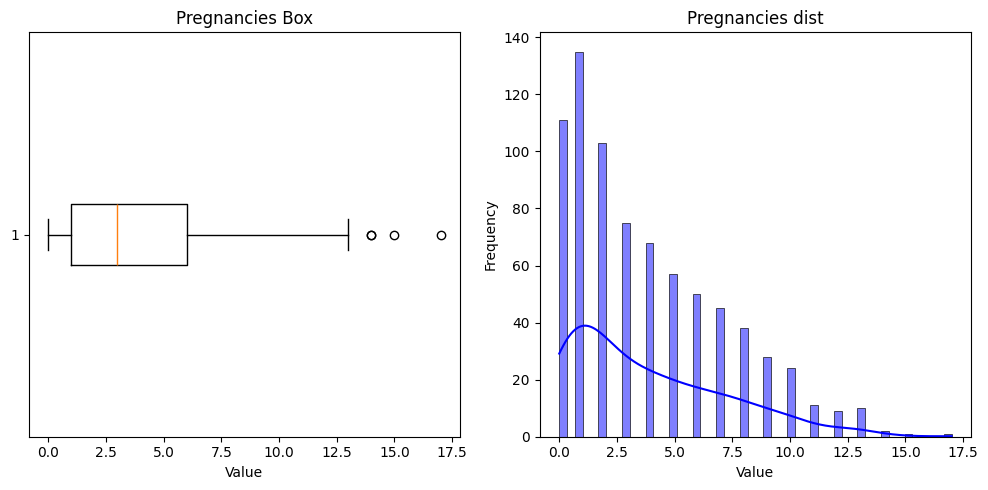

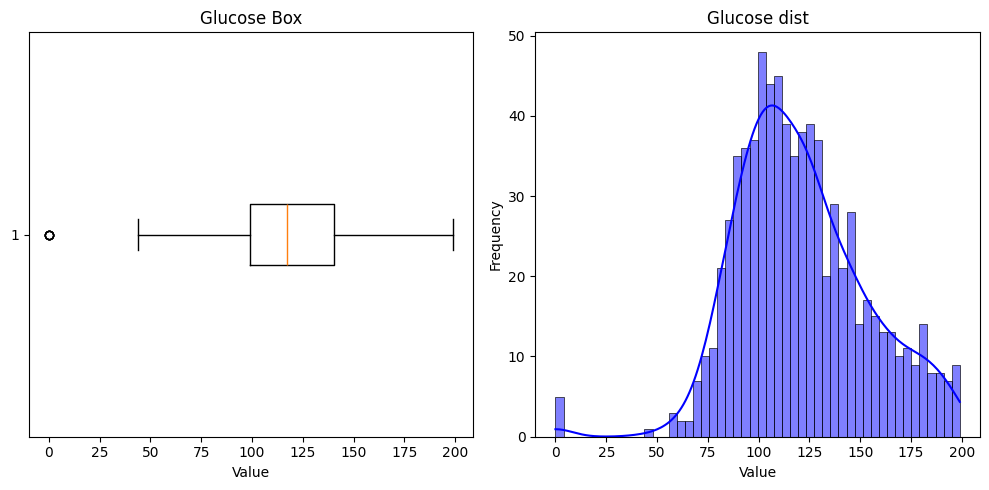

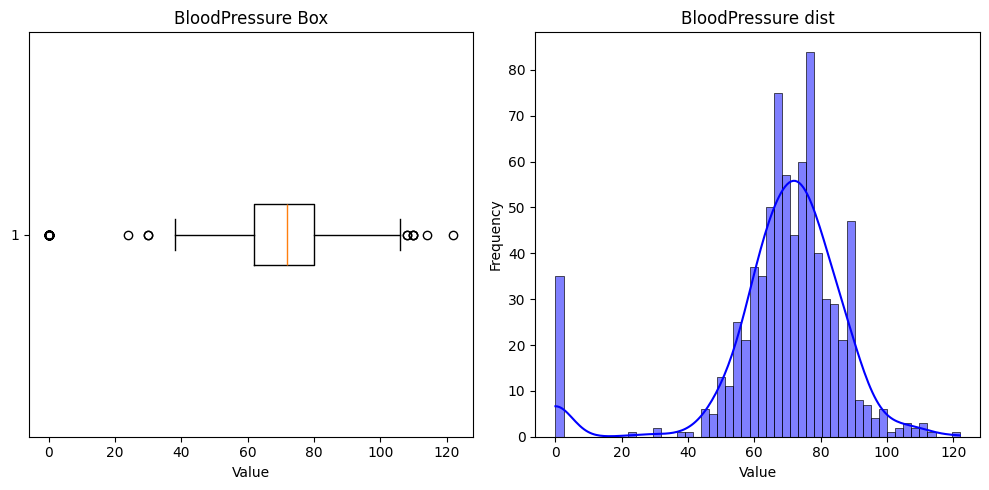

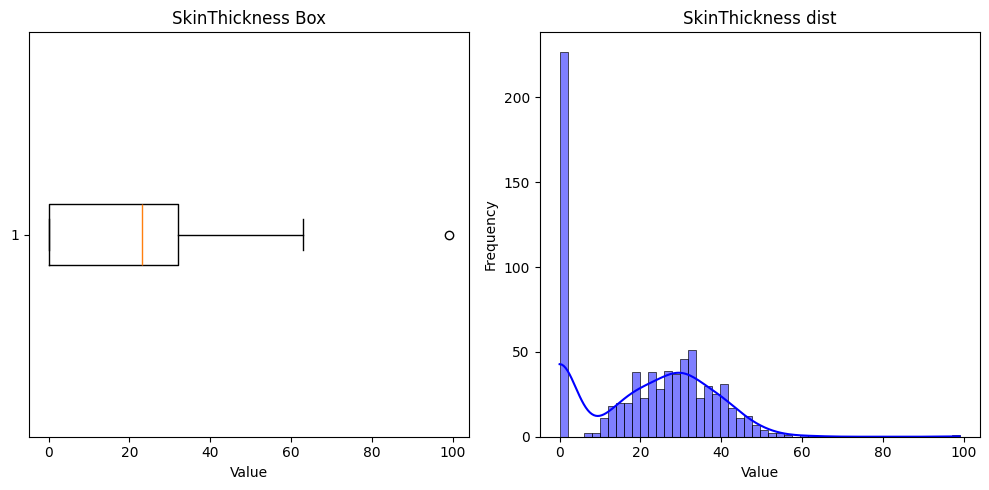

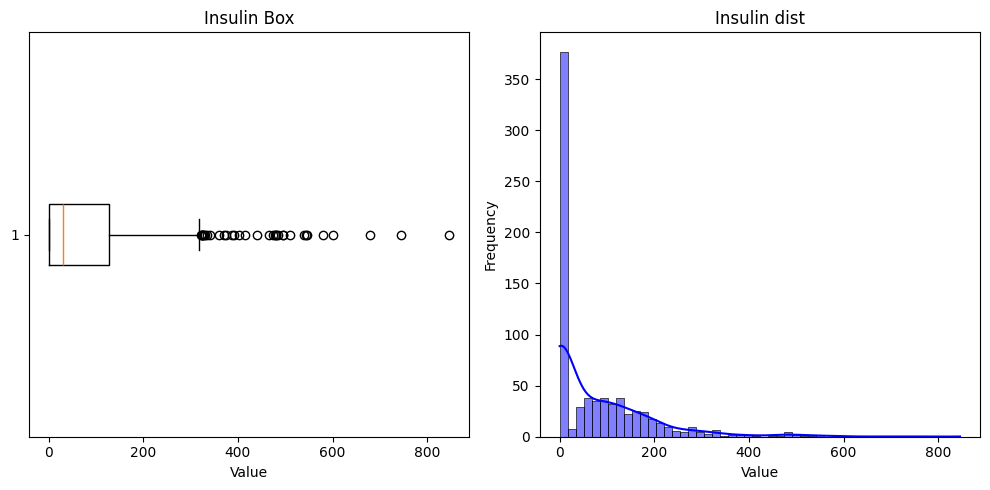

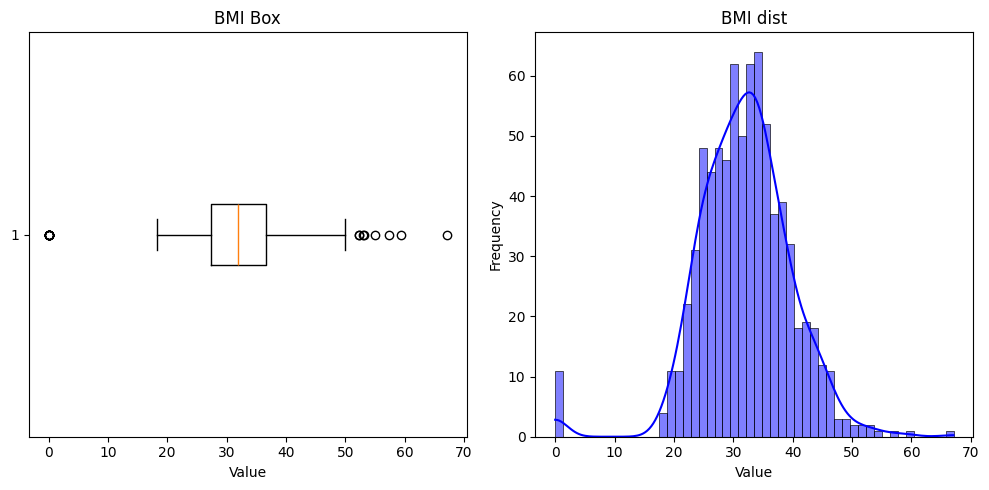

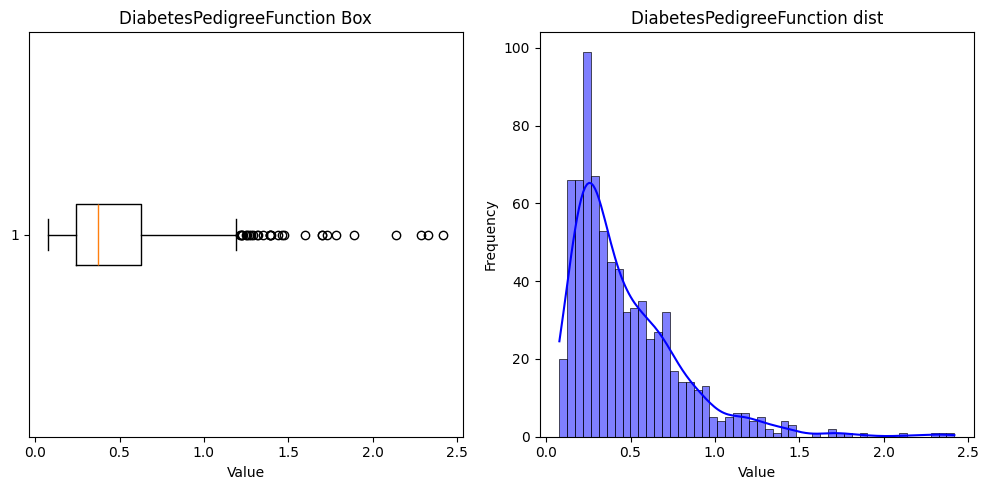

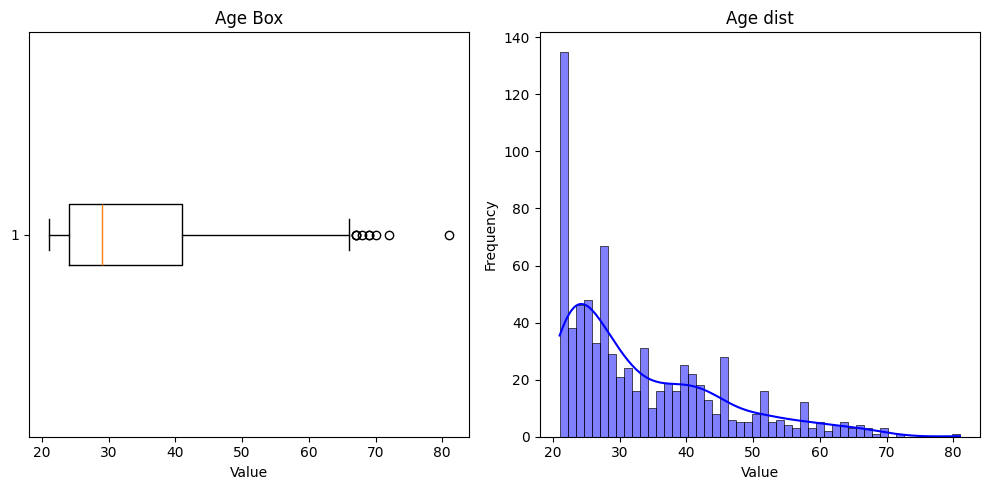

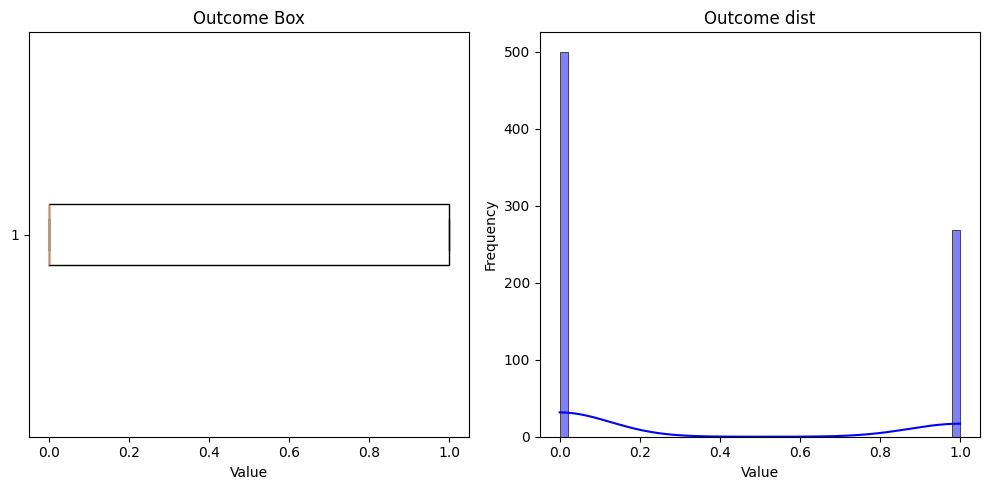

In [44]:
columns = df.columns
for column in columns:
    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

        ax_box.boxplot(df[column], vert=False, whis=1.5)
        ax_box.set_xlabel('Value')
        ax_box.set_title(f'{column} Box')

        sns.histplot(df[column], bins=50, color='blue', kde=True, ax=ax_hist)
        ax_hist.set_xlabel('Value')
        ax_hist.set_ylabel('Frequency')
        ax_hist.set_title(f'{column} dist')

        # Show plot
        plt.tight_layout()
        plt.show()

### Its clear from the above EDA that Outcome is the target
### BMI has distribution which has massive outlier
### Insulin has some outlier

In [45]:
df.duplicated().sum()

np.int64(0)

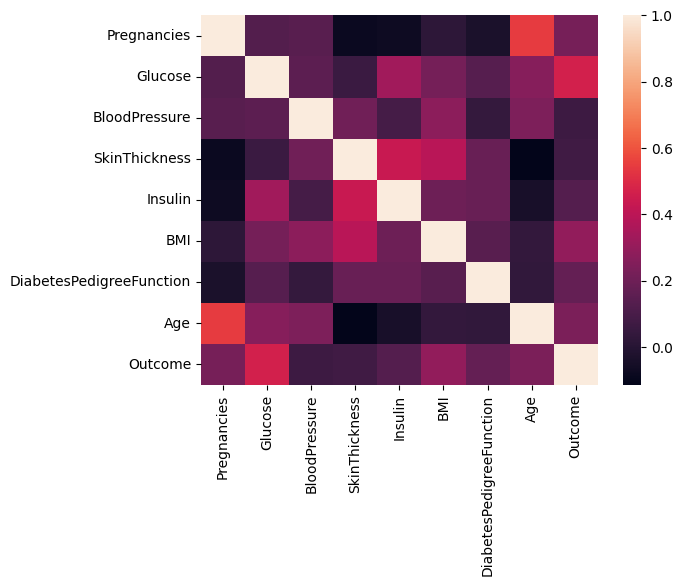

In [46]:
x=df.corr()
sns.heatmap(x)
plt.show()

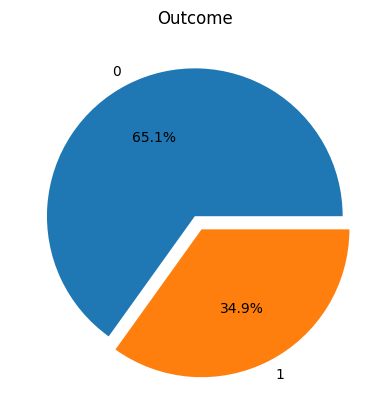

In [47]:
x=df['Outcome'].value_counts()
plt.pie(x,explode=[0, 0.1], autopct='%1.1f%%',labels=[0,1])
plt.title("Outcome")
plt.show()

In [48]:
x=df.columns
for col in x:
    num_zeros=df[col].eq(0).sum()
    print(num_zeros," in ",col)

111  in  Pregnancies
5  in  Glucose
35  in  BloodPressure
227  in  SkinThickness
374  in  Insulin
11  in  BMI
0  in  DiabetesPedigreeFunction
0  in  Age
500  in  Outcome


#### 3. Set Target

- Set `Outcome` as target.
- Set Features

In [49]:
X=df.drop('Outcome', axis=1)
y = df['Outcome']

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y
- Find top 4 features
- Transform features to a DataFrame

In [50]:
# Create an instance of SelectKBest

from sklearn.feature_selection import SelectKBest, chi2

# Create an instance of SelectKBest with chi2 as the score function and k=4
select_kbest = SelectKBest(score_func=chi2, k=4)

In [51]:
# Fit

# Fit the SelectKBest instance to the data
fit = select_kbest.fit(X, y)

In [52]:
# Print Score
# Find Top 4 Featuresx

# Print the scores of the features
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': fit.scores_})
top_features = feature_scores.nlargest(4, 'Score')

In [53]:
# Transform X to Features

X_new = fit.transform(X)

In [54]:
# Transform features to a dataframe
X_new_df = pd.DataFrame(X_new, columns=top_features['Feature'])

In [55]:
(top_features, X_new_df.head())

(   Feature        Score
 4  Insulin  2175.565273
 1  Glucose  1411.887041
 7      Age   181.303689
 5      BMI   127.669343,
 Feature  Insulin  Glucose   Age   BMI
 0          148.0      0.0  33.6  50.0
 1           85.0      0.0  26.6  31.0
 2          183.0      0.0  23.3  32.0
 3           89.0     94.0  28.1  21.0
 4          137.0    168.0  43.1  33.0)

##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [56]:
# ANSWER

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression estimator
estimator = LogisticRegression(max_iter=1000, solver='liblinear')

# Create an RFE instance with the Logistic Regression estimator and select 4 features
rfe = RFE(estimator=estimator, n_features_to_select=4)

# Fit RFE
rfe.fit(X, y)

RFE(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    n_features_to_select=4)

In [57]:
# Print Score
# Find Features
# Get the selected features
selected_features = X.columns[rfe.support_]

selected_features

Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction'], dtype='object')

#### Bonus 5 :  Run KNN with selected features

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Extract the selected features
X_rfe = X[selected_features]

# Split the data into training and testing sets with the selected features
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler_rfe = StandardScaler()
X_train_rfe = scaler_rfe.fit_transform(X_train_rfe)
X_test_rfe = scaler_rfe.transform(X_test_rfe)

# Initialize the KNN classifier
knn_rfe = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_rfe.fit(X_train_rfe, y_train_rfe)

# Make predictions
y_pred_rfe = knn_rfe.predict(X_test_rfe)

# Evaluate the model's performance
conf_matrix_rfe = confusion_matrix(y_test_rfe, y_pred_rfe)
class_report_rfe = classification_report(y_test_rfe, y_pred_rfe)
accuracy_rfe = accuracy_score(y_test_rfe, y_pred_rfe)

# Display results
conf_matrix_df = pd.DataFrame(conf_matrix_rfe, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print("Confusion Matrix:\n", conf_matrix_df)
print("\nClassification Report:\n", class_report_rfe)
print("\nAccuracy:", accuracy_rfe)

(conf_matrix_rfe, class_report_rfe, accuracy_rfe)


Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                  82                  17
Actual Positive                  20                  35

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82        99
           1       0.67      0.64      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.76      0.76       154


Accuracy: 0.7597402597402597


(array([[82, 17],
        [20, 35]]),
 '              precision    recall  f1-score   support\n\n           0       0.80      0.83      0.82        99\n           1       0.67      0.64      0.65        55\n\n    accuracy                           0.76       154\n   macro avg       0.74      0.73      0.74       154\nweighted avg       0.76      0.76      0.76       154\n',
 0.7597402597402597)

#### Bonus 5.1 : Lets Tune using hyper parameters

In [59]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_rfe, y_train_rfe)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test data
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_rfe)
accuracy_best = accuracy_score(y_test_rfe, y_pred_best)
conf_matrix_best = confusion_matrix(y_test_rfe, y_pred_best)
class_report_best = classification_report(y_test_rfe, y_pred_best)

# Display results
conf_matrix_df = pd.DataFrame(conf_matrix_best, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print("Best Parameters:\n", best_params)
print("\nBest Cross-Validation Score:\n", best_score)
print("\nAccuracy on Test Data:\n", accuracy_best)
print("\nConfusion Matrix:\n", conf_matrix_df)
print("\nClassification Report:\n", class_report_best)

(best_params, best_score, accuracy_best, class_report_best)


Best Parameters:
 {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}

Best Cross-Validation Score:
 0.7459416233506597

Accuracy on Test Data:
 0.7922077922077922

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                  86                  13
Actual Positive                  19                  36

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84        99
           1       0.73      0.65      0.69        55

    accuracy                           0.79       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



({'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'},
 np.float64(0.7459416233506597),
 0.7922077922077922,
 '              precision    recall  f1-score   support\n\n           0       0.82      0.87      0.84        99\n           1       0.73      0.65      0.69        55\n\n    accuracy                           0.79       154\n   macro avg       0.78      0.76      0.77       154\nweighted avg       0.79      0.79      0.79       154\n')



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



